In [34]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("HistoricalData_1715332591456.csv")
df

,Date,Close/Last,Open,High,Low
0,05/09/2024,5214.08,5189.03,5215.30,5180.41
1,05/08/2024,5187.67,5168.98,5191.95,5165.86
2,05/07/2024,5187.70,5187.20,5200.23,5178.96
3,05/06/2024,5180.74,5142.42,5181.00,5142.42
4,05/03/2024,5127.79,5122.78,5139.12,5101.22
...,...,...,...,...,...
2526,05/16/2014,1877.86,1871.19,1878.28,1864.82
2527,05/15/2014,1870.85,1888.16,1888.16,1862.36
2528,05/14/2014,1888.53,1897.13,1897.13,1885.77
2529,05/13/2014,1897.45,1896.75,1902.17,1896.06


In [35]:
# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
Date          0
Close/Last    0
Open          0
High          0
Low           0
dtype: int64


In [3]:
#mean_open = df['open'].mean()
#mean_high = df['high'].mean()
#mean_low = df['low'].mean()

In [4]:
# Fill missing values with the mean of each column separately
#df['open'].fillna(mean_open, inplace=True)
#df['high'].fillna(mean_high, inplace=True)
#df['low'].fillna(mean_low, inplace=True)

In [36]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Extract the numeric columns for scaling
numeric_columns = ['Open', 'High', 'Low', 'Close/Last']

# Separate the numeric data
numeric_data = df[numeric_columns]

# Perform normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numeric_data)

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data, columns=numeric_columns)

# Perform standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_data)

# Convert the standardized data back to a DataFrame
df_standardized = pd.DataFrame(standardized_data, columns=numeric_columns)

# Combine the non-numeric columns with the scaled numeric columns
df_scaled = pd.concat([df[['Date']], df_normalized], axis=1)  # For normalized data
# df_scaled = pd.concat([df[['date', 'Name']], df_standardized], axis=1)  # For standardized data

# Display the scaled DataFrame
df_scaled.head()


,Date,Open,High,Low,Close/Last
0,05/09/2024,0.986888,0.990589,0.987531,0.988243
1,05/08/2024,0.983075,0.986153,0.984757,0.980533
2,05/07/2024,0.986540,0.987726,0.987255,0.980542
3,05/06/2024,0.978024,0.984074,0.980289,0.978510
4,05/03/2024,0.974289,0.976119,0.972435,0.963051


In [37]:
# Convert ORDERDATE to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set ORDERDATE as the index
df.set_index('Date', inplace=True)

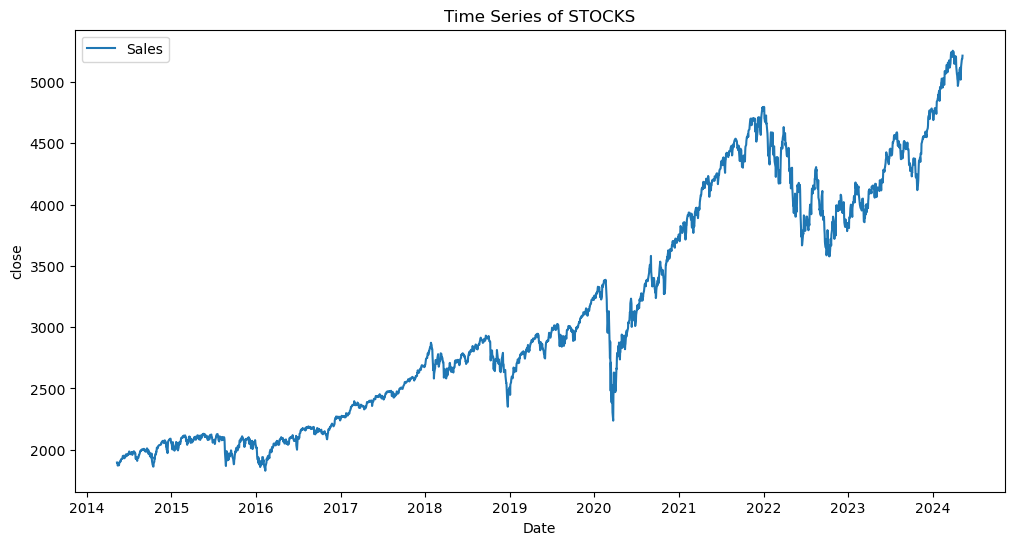

In [38]:
# Visualize the time series data
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close/Last'], label='Sales')
plt.title('Time Series of STOCKS')
plt.xlabel('Date')
plt.ylabel('close')
plt.legend()
plt.show()


# ARIMA MODEL

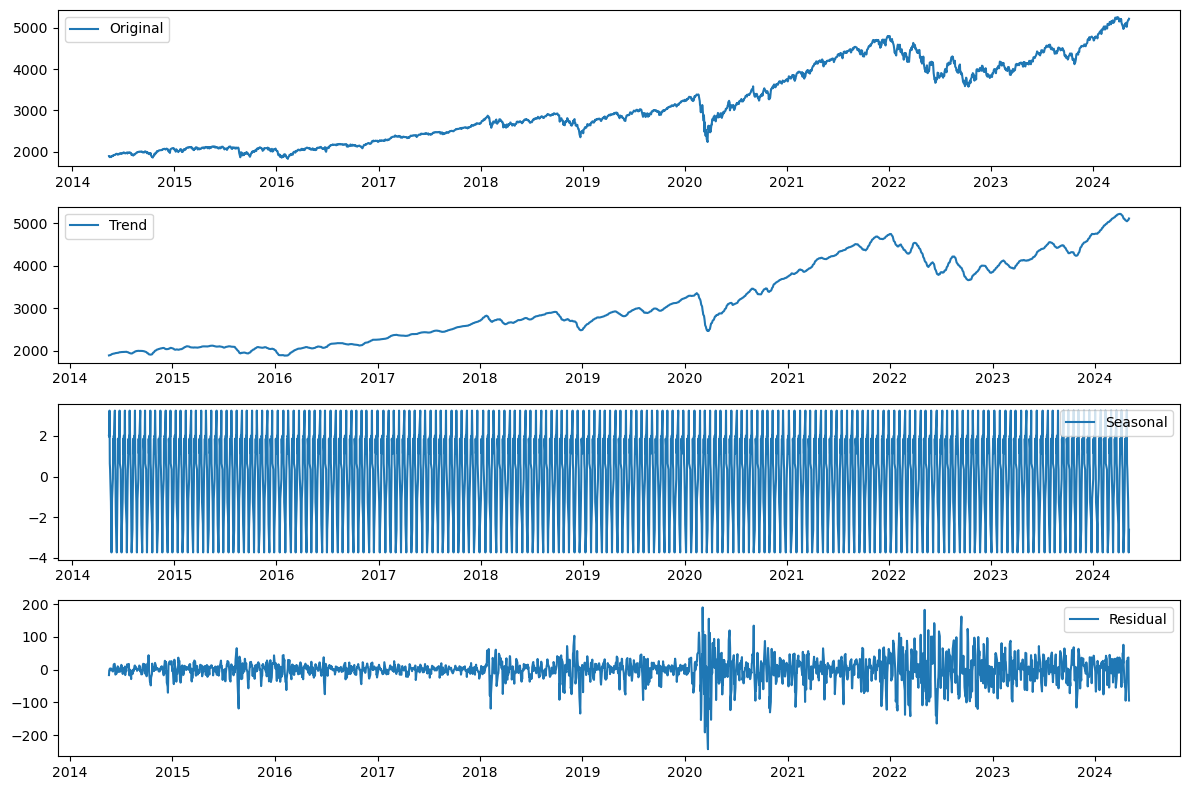

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Close/Last'], period=13)  # Adjust the period based on your data

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df.index, df['Close/Last'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(df.index, decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(df.index, decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(df.index, decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
import numpy as np

# Apply Differencing to the 'Close/Last' column
df['Close/Last_diff'] = df['Close/Last'].diff()

# Apply Logarithmic Transformation to the 'Close/Last' column
df['Close/Last_log'] = np.log(df['Close/Last'])

# Apply Differencing to selected columns: 'Open', 'High', 'Low'
df[['Open_diff', 'High_diff', 'Low_diff']] = df[['Open', 'High', 'Low']].diff()

# Apply Logarithmic Transformation to selected columns: 'Open', 'High', 'Low'
df[['Open_log', 'High_log', 'Low_log']] = np.log(df[['Open', 'High', 'Low']])

# Drop original columns: 'Open', 'High', 'Low', 'Close/Last'
df.drop(['Open', 'High', 'Low', 'Close/Last'], axis=1, inplace=True)


df.dropna(inplace=True)


df.head()


C:\Users\HP\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,Close/Last_diff,Close/Last_log,Open_diff,High_diff,Low_diff,Open_log,High_log,Low_log
Date,,,,,,,,
2024-05-08,-26.41,8.554040,-20.05,-23.35,-14.55,8.550431,8.554865,8.549827
2024-05-07,0.03,8.554046,18.22,8.28,13.10,8.553949,8.556458,8.552360
2024-05-06,-6.96,8.552703,-44.78,-19.23,-36.54,8.545279,8.552753,8.545279
2024-05-03,-52.95,8.542430,-19.64,-41.88,-41.20,8.541453,8.544637,8.537235
2024-05-02,-63.59,8.529951,-73.46,-65.91,-90.17,8.527009,8.531729,8.519401


In [41]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis: Data is stationary")
    else:
        print("Fail to reject the null hypothesis: Data is non-stationary")

def kpss_test(series):
    result = kpss(series)
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis: Data is non-stationary")
    else:
        print("Fail to reject the null hypothesis: Data is stationary")

print("ADF Test:")
adf_test(df['Close/Last_diff'])
print("\nKPSS Test:")
kpss_test(df['Close/Last_diff'])


ADF Test:
ADF Statistic: -15.595086017353687
p-value: 1.8592260084341665e-28
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject the null hypothesis: Data is stationary

KPSS Test:
KPSS Statistic: 0.10047402196845716
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Fail to reject the null hypothesis: Data is stationary


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


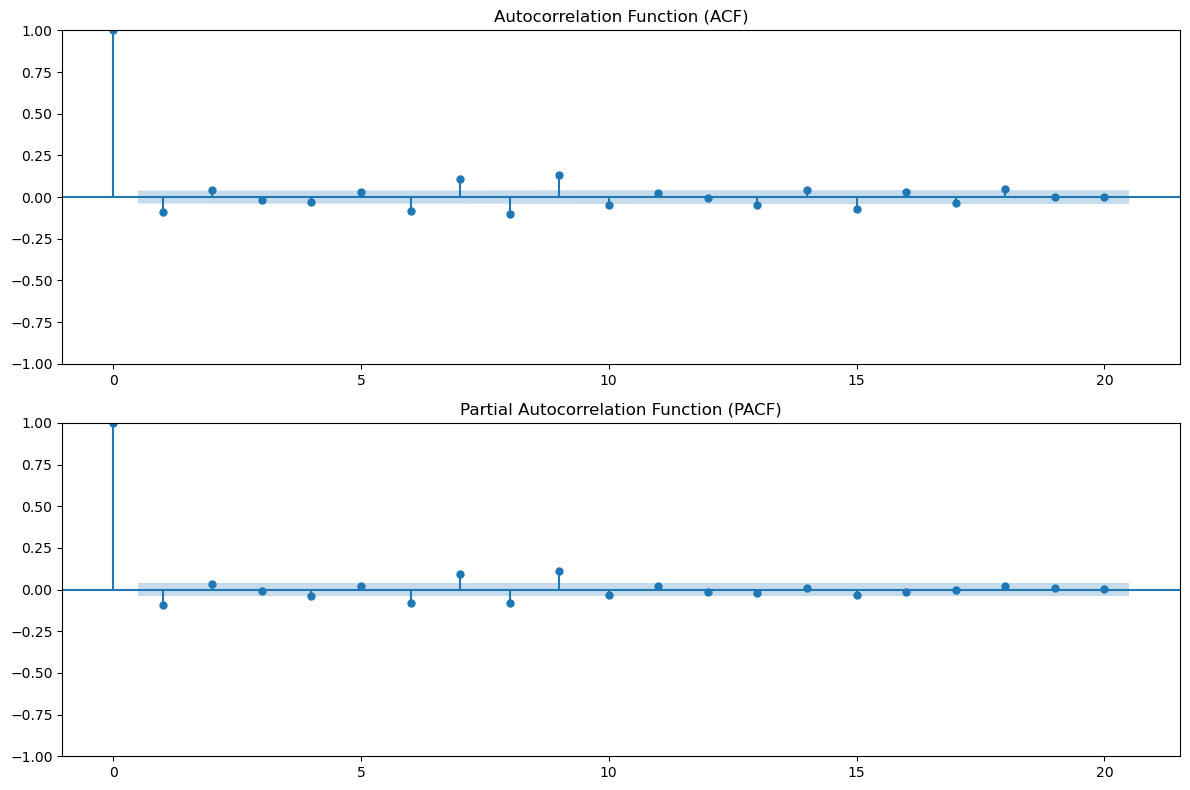

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df['Close/Last_diff'], ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(df['Close/Last_diff'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


p = 1 
d = 1  
q = 1 


train_data = df['Close/Last_diff'].iloc[:-12]  


arima_model = ARIMA(train_data, order=(p, d, q))
arima_result = arima_model.fit()


print(arima_result.summary())


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsm

                               SARIMAX Results                                
Dep. Variable:        Close/Last_diff   No. Observations:                 2518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12555.942
Date:                Tue, 14 May 2024   AIC                          25117.884
Time:                        20:05:49   BIC                          25135.376
Sample:                             0   HQIC                         25124.232
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0899      0.010     -9.348      0.000      -0.109      -0.071
ma.L1         -0.9997      0.007   -135.111      0.000      -1.014      -0.985
sigma2      1256.5151     19.522     64.365      0.0

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


test_data = df['Close/Last_diff'].iloc[-12:]  # Using the last 12 months for testing


forecast = arima_result.forecast(steps=len(test_data))


mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, forecast)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-Squared Score:", r2)


accuracy = r2 * 100
print(f"Model accuracy: {accuracy:.2f}% based on R-Squared Score.")

# Check if accuracy is above 90%
if accuracy > 90:
    print("Model accuracy is above 90%.")
else:
    print("Model accuracy is below 90%.")


Mean Absolute Error (MAE): 7.716867496940236
Mean Squared Error (MSE): 89.44922357044003
Root Mean Squared Error (RMSE): 9.457759965786826
R-Squared Score: 0.005537693744219974
Model accuracy: 0.55% based on R-Squared Score.
Model accuracy is below 90%.


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\AppData\Local\Temp\ipykernel_18368\228175109.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


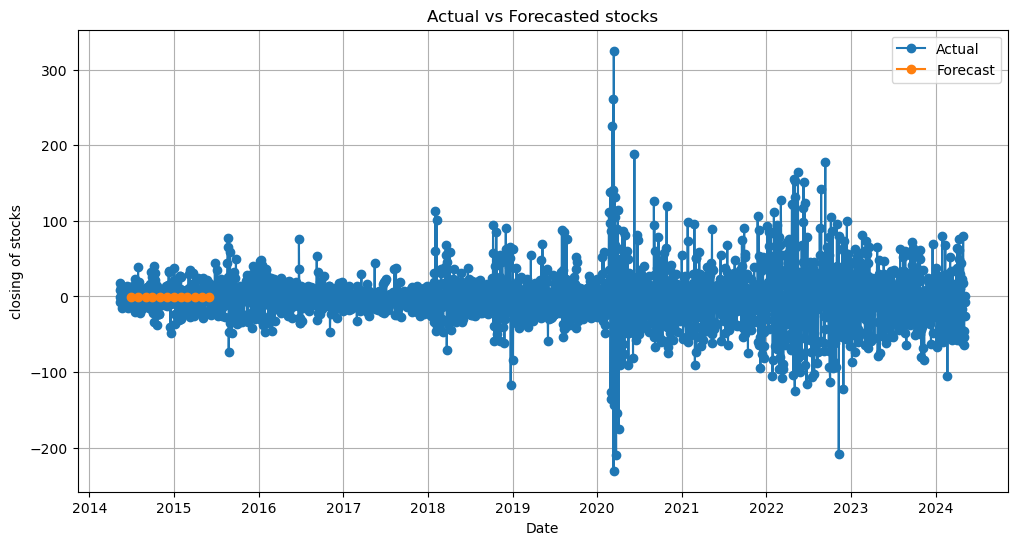

In [14]:
import matplotlib.pyplot as plt

forecast_values = arima_result.forecast(steps=12)

forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close/Last_diff'], label='Actual', marker='o')
plt.plot(forecast_dates, forecast_values, label='Forecast', marker='o')
plt.title('Actual vs Forecasted stocks')
plt.xlabel('Date')
plt.ylabel('closing of stocks')
plt.legend()
plt.grid(True)
plt.show()


# ANN MODEL

C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: nan - val_loss: nan
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: nan
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 13/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: n

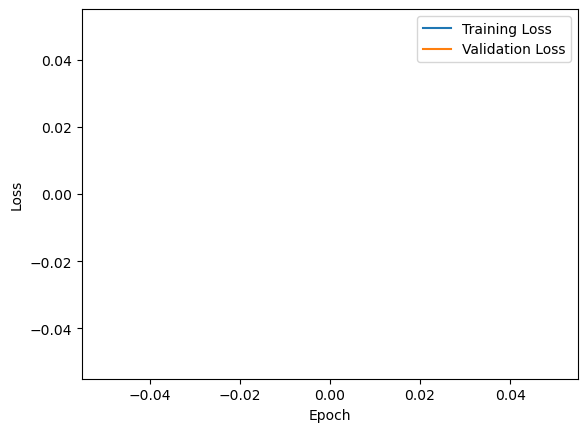

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam



X = df.drop('Close/Last_diff', axis=1)  
y = df['Close/Last_diff']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  
])


model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


predictions = model.predict(X_test)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:

loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan 
Test Loss (MSE): nan


In [17]:

predictions = model.predict(X_test).flatten()


mape = np.mean(np.abs((y_test.values - predictions) / y_test.values)) * 100


print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Percentage Error (MAPE): nan%


# SARIMA MODEL

ADF Statistic: -15.595086017353687
p-value: 1.8592260084341665e-28


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


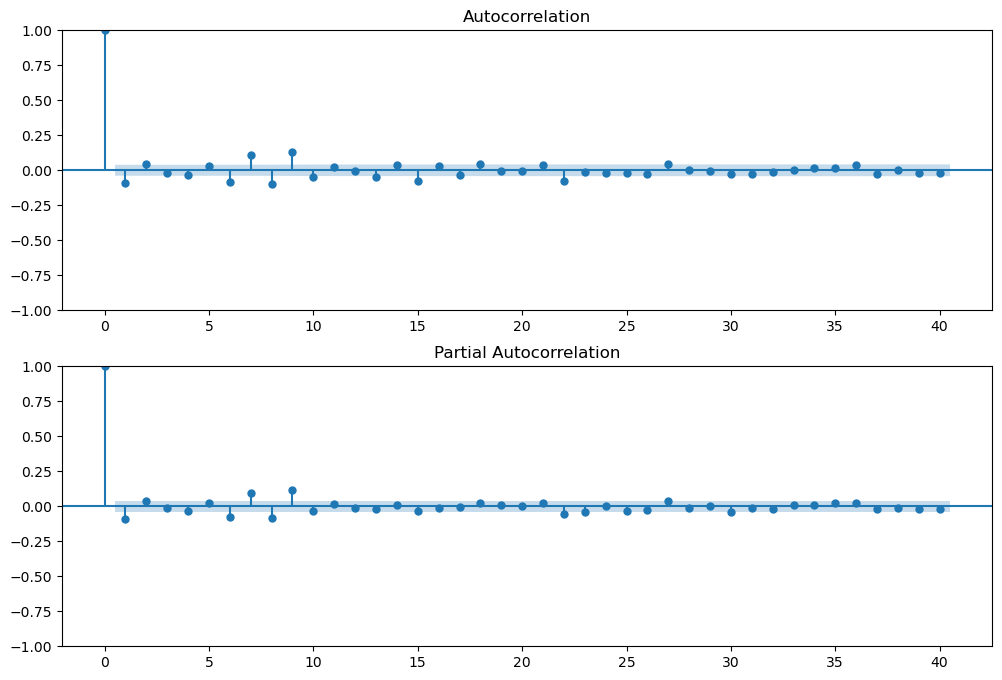

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


result = adfuller(df['Close/Last_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot ACF and PACF plots for seasonal parameters estimation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(df['Close/Last_diff'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Close/Last_diff'], lags=40, ax=ax[1])
plt.show()



C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                    Close/Last_diff   No. Observations:                 2530
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood              -12597.089
Date:                            Tue, 14 May 2024   AIC                          25200.178
Time:                                    17:29:46   BIC                          25217.670
Sample:                                         0   HQIC                         25206.526
                                           - 2530                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9996      0.016    -63.951      0.000      -1.030      -0.969
ma.S.L12      -0.9985      0.052   

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


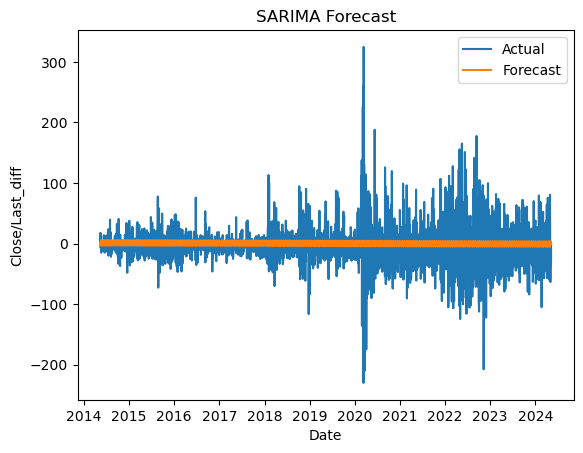

In [19]:
# Define SARIMA model
model = sm.tsa.statespace.SARIMAX(df['Close/Last_diff'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))

results = model.fit()


print(results.summary())


forecast = results.forecast(steps=len(df))  


plt.plot(df.index, df['Close/Last_diff'], label='Actual')
plt.plot(df.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Close/Last_diff')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae = mean_absolute_error(df['Close/Last_diff'], forecast)


mse = mean_squared_error(df['Close/Last_diff'], forecast)


rmse = np.sqrt(mse)

   
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 23.156000497979168
Mean Squared Error (MSE): 1269.6446693245516
Root Mean Squared Error (RMSE): 35.63207360405161


# Exponential Smoothing (ETS)

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df['Close/Last_diff'], trend='add', seasonal='add', seasonal_periods=12)


fitted_model = model.fit()


forecast = fitted_model.forecast(12)

print("Forecasted values:", forecast)


print(fitted_model.summary())

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecasted values: 2530    2.329311
2531   -1.789434
2532    2.456657
2533   -0.513011
2534   -4.368789
2535   -3.639766
2536   -0.843049
2537   -2.215160
2538   -3.482138
2539   -3.508182
2540   -0.617255
2541   -6.550810
dtype: float64
                       ExponentialSmoothing Model Results                       
Dep. Variable:          Close/Last_diff   No. Observations:                 2530
Model:             ExponentialSmoothing   SSE                        3492394.009
Optimized:                         True   AIC                          18324.212
Trend:                         Additive   BIC                          18417.588
Seasonal:                      Additive   AICC                         18324.485
Seasonal Periods:                    12   Date:                 Tue, 14 May 2024
Box-Cox:                          False   Time:                         17:29:48
Box-Cox Coeff.:                    None                                         
                          coeff  

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error


model = ExponentialSmoothing(df['Close/Last_diff'], trend='add', seasonal='add', seasonal_periods=12)


fitted_model = model.fit()


forecast = fitted_model.forecast(12)


actual_values = df['Close/Last_diff'][-12:]  

mae = mean_absolute_error(actual_values, forecast)


percentage_accuracy = 1 - (mae / actual_values.mean())  # Percentage of accuracy


print("Forecasted values:", forecast)

# Print MAE and Percentage of Accuracy
print("Mean Absolute Error (MAE):", mae)
print("Percentage of Accuracy:", percentage_accuracy)


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecasted values: 2530    2.329311
2531   -1.789434
2532    2.456657
2533   -0.513011
2534   -4.368789
2535   -3.639766
2536   -0.843049
2537   -2.215160
2538   -3.482138
2539   -3.508182
2540   -0.617255
2541   -6.550810
dtype: float64
Mean Absolute Error (MAE): 7.460580435976257
Percentage of Accuracy: 7.81850458733556


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# Prophet

In [45]:
import pandas as pd


df = pd.read_csv("HistoricalData_1715332591456.csv")
df

,Date,Close/Last,Open,High,Low
0,05/09/2024,5214.08,5189.03,5215.30,5180.41
1,05/08/2024,5187.67,5168.98,5191.95,5165.86
2,05/07/2024,5187.70,5187.20,5200.23,5178.96
3,05/06/2024,5180.74,5142.42,5181.00,5142.42
4,05/03/2024,5127.79,5122.78,5139.12,5101.22
...,...,...,...,...,...
2526,05/16/2014,1877.86,1871.19,1878.28,1864.82
2527,05/15/2014,1870.85,1888.16,1888.16,1862.36
2528,05/14/2014,1888.53,1897.13,1897.13,1885.77
2529,05/13/2014,1897.45,1896.75,1902.17,1896.06


21:57:56 - cmdstanpy - INFO - Chain [1] start processing
21:57:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\HP\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\HP\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\HP\anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return

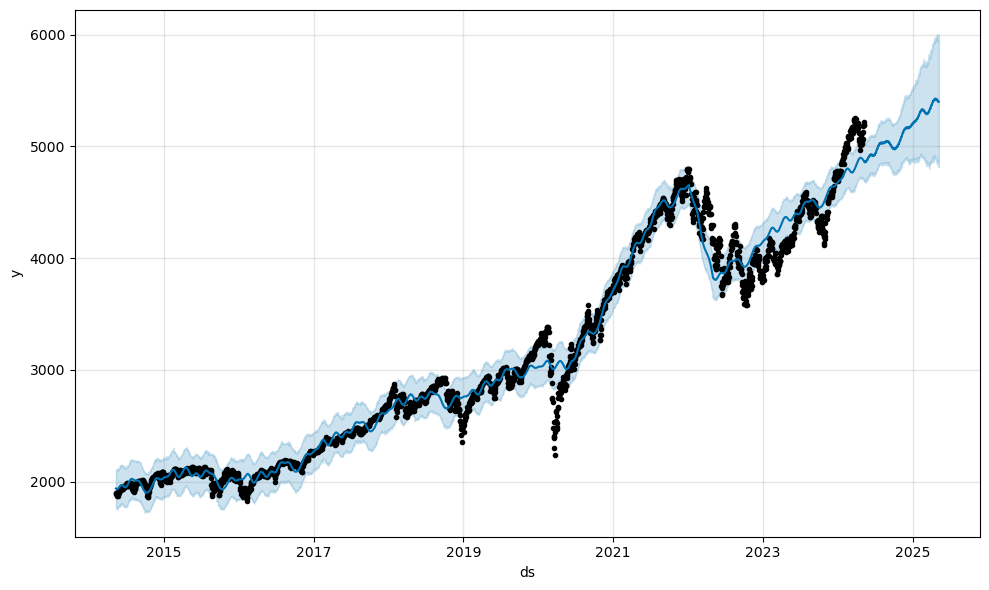

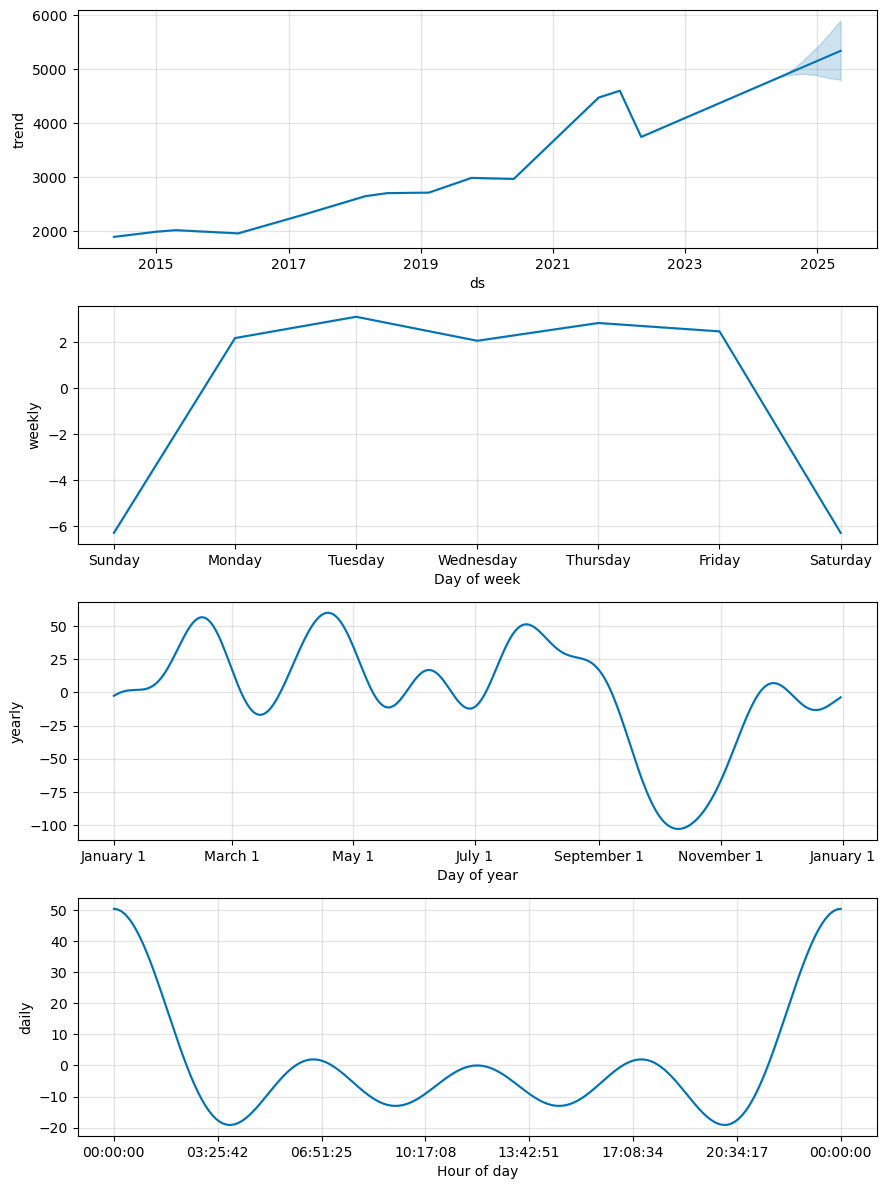

             ds         yhat   yhat_lower   yhat_upper
2891 2025-05-05  5406.955162  4875.018933  5966.154182
2892 2025-05-06  5405.607959  4847.396910  5938.027425
2893 2025-05-07  5402.384645  4816.606810  5972.223987
2894 2025-05-08  5401.113837  4836.247274  5977.278142
2895 2025-05-09  5398.885763  4817.690768  5996.185097


In [46]:
import pandas as pd
from prophet import Prophet



df_prophet = pd.DataFrame({
    'ds': df['Date'],
    'y': df['Close/Last']
})

model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

model.fit(df_prophet)

future_dates = model.make_future_dataframe(periods=365)  # For example, predict the next year

forecast = model.predict(future_dates)

fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)

plt.show()

predicted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(predicted_values.tail())

# Support Vector Regression (SVR)

In [25]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("HistoricalData_1715332591456.csv")
df

,Date,Close/Last,Open,High,Low
0,05/09/2024,5214.08,5189.03,5215.30,5180.41
1,05/08/2024,5187.67,5168.98,5191.95,5165.86
2,05/07/2024,5187.70,5187.20,5200.23,5178.96
3,05/06/2024,5180.74,5142.42,5181.00,5142.42
4,05/03/2024,5127.79,5122.78,5139.12,5101.22
...,...,...,...,...,...
2526,05/16/2014,1877.86,1871.19,1878.28,1864.82
2527,05/15/2014,1870.85,1888.16,1888.16,1862.36
2528,05/14/2014,1888.53,1897.13,1897.13,1885.77
2529,05/13/2014,1897.45,1896.75,1902.17,1896.06


In [26]:
df['Date'] = pd.to_datetime(df['Date'])

In [27]:
# Drop rows with missing values
df.dropna(inplace=True)

X = df[['Date']]
y = df['Close/Last']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

y_train = np.array(y_train)
y_test = np.array(y_test)

Mean Squared Error: 1023389.782445202


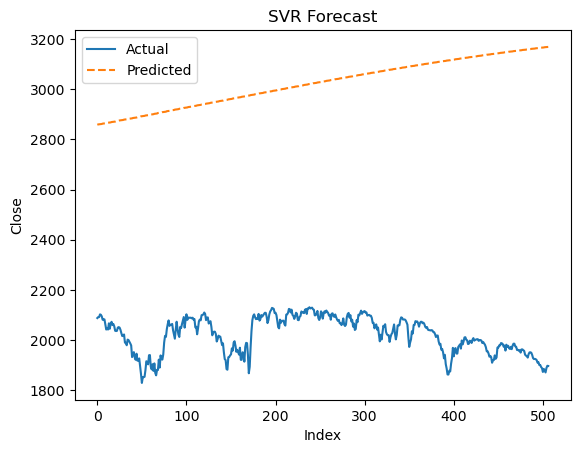

In [28]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


svr_model = SVR(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel with default parameters
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot predictions
plt.plot(np.arange(len(y_test)), y_test, label='Actual')  # Using numpy.arange to create a sequence of indices
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Close')
plt.title('SVR Forecast')
plt.legend()
plt.show()

# Long Short-Term Memory (LSTM)

C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 12294528.0000 - val_loss: 4090770.0000
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12111034.0000 - val_loss: 4091105.0000
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12338632.0000 - val_loss: 4091665.7500
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11944605.0000 - val_loss: 4092375.2500
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12074100.0000 - val_loss: 4092928.7500
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12226190.0000 - val_loss: 4093182.5000
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12151940.0000 - val_loss: 4093005.0000
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11971220.0000 - val_loss: 4092157.7500
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12000745.0000 - val_loss: 4090732.5000
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12021272.0000 - val_loss: 4088463.7500
Epoch 11/100
64/64

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11095702.0000 - val_loss: 3412335.5000
Epoch 63/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11032942.0000 - val_loss: 3400713.5000
Epoch 64/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10985520.0000 - val_loss: 3389403.7500
Epoch 65/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10803646.0000 - val_loss: 3378168.2500
Epoch 66/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10800945.0000 - val_loss: 3367045.7500
Epoch 67/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10974913.0000 - val_loss: 3356172.5000
Epoch 68/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10961619.0000 - val_loss: 3344956.7500
Epoch 69/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10791800.0000 - val_loss: 3334191.2500
Epoch 70/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10817101.0000 - val_loss: 3323413.2500
Epoch 71/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10915615.0000 - val_loss: 3312693.0000
Epoch 72/100
64/64 ━━━━

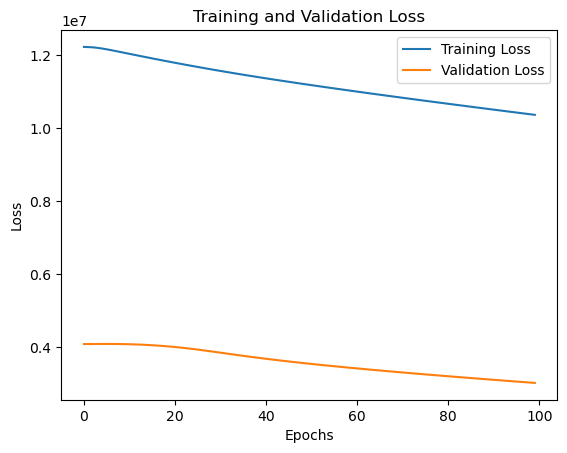

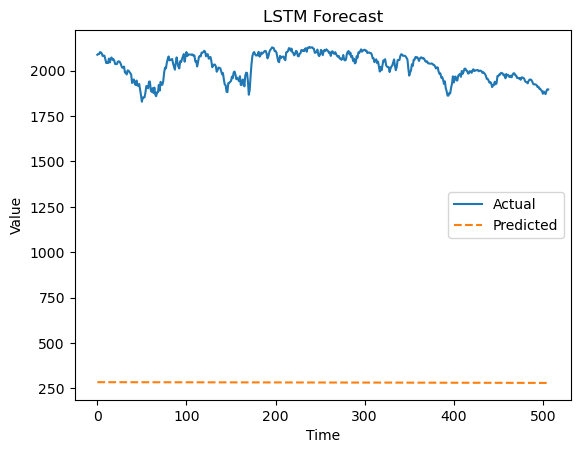

In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])

model.compile(optimizer=Adam(), loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

In [31]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


svr_model = SVR(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel with default parameters
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


transformed = y_test  

# Plot predictions
plt.plot(np.arange(len(y_test)), y_test, label='Actual')  # Using numpy.arange to create a sequence of indices
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Close')
plt.title('SVR Forecast')
plt.legend()
plt.savefig('svr_forecast.png')
plt.close()


mean_value = np.mean(transformed)
accuracy = (1 - rmse / mean_value) * 100
print(f"Model accuracy: {accuracy:.2f}% based on RMSE.")

# Check if accuracy is above 90%
if accuracy > 90:
    print("Model accuracy is above 90%.")
else:
    print("Model accuracy is below 90%.")


Mean Squared Error: 1023389.782445202
Root Mean Squared Error: 1011.6272942369645
Model accuracy: 49.95% based on RMSE.
Model accuracy is below 90%.


# HYBRID MODEL

In [47]:
from keras.models import Sequential
from keras.layers import Dense

# First, fit an ARIMA model
arima_model = ARIMA(df['Close/Last'], order=(1, 1, 1))
arima_res = arima_model.fit()


residuals = arima_res.resid

# Use these residuals as input features to an ANN
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit ANN
model.fit(residuals.values.reshape(-1, 1), df['Close/Last'], epochs=50, verbose=0)


ann_predictions = model.predict(residuals.values.reshape(-1, 1))

C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
